**Table of contents**<a id='toc0_'></a>    
- 1. [Preface](#toc1_)    
- 2. [C++ module](#toc2_)    
- 3. [Algorithms](#toc3_)    
  - 3.1. [Relationship](#toc3_1_)    
  - 3.2. [Diversity](#toc3_2_)    
    - 3.2.1. [Richness Index](#toc3_2_1_)    
    - 3.2.2. [Shannon Diversity Index](#toc3_2_2_)    
    - 3.2.3. [Simpson Diversity Index](#toc3_2_3_)    
    - 3.2.4. [Pielou's Evenness Index](#toc3_2_4_)    
    - 3.2.5. [Bray-Curtis 相似性指数](#toc3_2_5_)    
    - 3.2.6. [Jaccard 相似性指数](#toc3_2_6_)    
- 4. [Diversity Analysis](#toc4_)    
  - 4.1. [Read datas](#toc4_1_)    
    - 4.1.1. [OTU table](#toc4_1_1_)    
    - 4.1.2. [Metainformation table](#toc4_1_2_)    
- 5. [Network analysis](#toc5_)    
- 6. [Convert](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Preface](#toc0_)

I plan rewritte all agrithms with PyTorch, and could run on GPU device.

<div style="display:flex;justify-content:center">

```mermaid
graph TD
    python[Python tool] --"PyTorch, Numpy"--> algorithm[Algorithm];
    math[Math background] --"Diversity"--> algorithm[Algorithm];
```

</div>

# 2. <a id='toc2_'></a>[C++ module](#toc0_)

- **pearson.cpp**
```bash
#include <pybind11/pybind11.h>
#include <pybind11/stl.h>

...

namespace py = pybind11;

PYBIND11_MODULE(pearson, m) {
    m.doc() = "Pearson correlation using C++";
    m.def("correlation", &pearson_correlation, "Compute Pearson correlation");
}
```

- **setup.py **
```bash
from setuptools import setup, Extension
import pybind11

ext_modules = [
    Extension(
        name="pearson",
        sources=["pearson.cpp"],
        include_dirs=[pybind11.get_include()],
        language="c++",
    )
]

setup(
    name="pearson",
    version="0.1",
    ext_modules=ext_modules,
)

```

- **setup.cfg**
```bash
[build_ext]
compiler = mingw32
```

- **打包**
```bash
python setup.py build_ext --inplace

```

In [5]:
# from pearson_module import pearson


# x = [1, 2, 3, 4, 5]
# y = [2, 4, 6, 8, 10]

# r = pearson.correlation(x, y)
# print(f"Pearson correlation: {r:.4f}")

# 3. <a id='toc3_'></a>[Algorithms](#toc0_)

## 3.1. <a id='toc3_1_'></a>[Relationship](#toc0_)

In [6]:
#@save
import torch 


def pearson(X:torch.Tensor, Y:torch.Tensor) -> torch.Tensor:
   '''
   Pearson
   Args:
        X: tensor(N, )
        Y: tensor(N, )
    return:
        pearson: tensor
   '''
   X_centered = X - X.mean()
   Y_centered = Y - Y.mean()

   covariance = (X_centered * Y_centered).sum()
   x_std = torch.sqrt((X_centered ** 2).sum())
   y_std = torch.sqrt(torch.pow(Y_centered, 2).sum())
   
   r = covariance / (x_std * y_std)
   return r 



def spearman(X:torch.Tensor, Y:torch.Tensor) -> torch.Tensor:
   '''
   spearman
   Args:
       X, Y: tensor(N, )
   Return: 
       spearman: tensor
   '''
   d = X - Y
   n = len(X)
   r = 6 * (torch.pow(d, 2).sum()) / ((n-1)*(n**2))
   return r


def sparcc():
   pass 

pearson: 1.00/1.00
spearman: 0.07/0.07


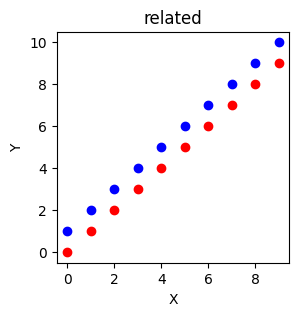

In [7]:
import matplotlib.pyplot as plt 
from scipy.stats import pearsonr, spearmanr


# calc pearson
X = torch.arange(10, dtype= torch.float)
Y = torch.arange(10, dtype= torch.float) + 1


plt.figure(figsize= (3, 3))
plt.scatter(torch.arange(10), X, color= 'red')
plt.scatter(torch.arange(10), Y, color= "blue")
plt.title(f"related")
plt.xlabel("X")
plt.ylabel("Y")
print(f"pearson: {pearson(X, Y):.2f}/{pearsonr(X, Y).correlation:.2f}")
print(f"spearman: {spearman(X, Y):.2f}/{spearman(X, Y):.2f}")

## 3.2. <a id='toc3_2_'></a>[Diversity](#toc0_)

### 3.2.1. <a id='toc3_2_1_'></a>[Richness Index](#toc0_)

form: S = 物种总数

解释: 丰富度指数是最简单的多样性指标，仅计算群落中存在的不同物种数量，而不考虑物种的相对丰度。

In [8]:
#@save 
import torch


def richness_index(species_counts):
    """
    计算丰富度指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: int, 物种总数。
    """
    return torch.count_nonzero(species_counts).item()

In [9]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])  # 第一个群落的物种个体数

# 计算丰富度指数
richness = richness_index(species_counts)
print("Richness Index:", richness)

Richness Index: 4


form: $S_{\text{Chao1}} = S_{\text{obs}} + \frac{n_1 (n_1 - 1)}{2 (n_2 + 1)}$


其中：
- Sobs: 观测到的物种数量
- n1: 只出现一次的物种数量（单例）
- n2 : 出现两次的物种数量（双例）

解释: Chao1 指数利用稀有物种的频率来推测未观测到的物种数量，适合稀疏采样的数据。

In [10]:
#@save 
def chao1_richness(species_counts):
    """
    计算Chao1丰富度估计指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: float, Chao1估计值。
    """
    n1 = torch.sum(species_counts == 1)  # 单例物种数量
    n2 = torch.sum(species_counts == 2)  # 双例物种数量
    s_obs = richness_index(species_counts)  # 观测到的物种数量
    if n2 == 0:
        n2 = 1  # 避免除以零
    chao1 = s_obs + (n1 * (n1 - 1)) / (2 * (n2 + 1))
    return chao1.item()

In [11]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])

# 计算Chao1丰富度估计指数
chao1 = chao1_richness(species_counts)
print("Chao1 Richness Estimate:", chao1)

Chao1 Richness Estimate: 4.0


### 3.2.2. <a id='toc3_2_2_'></a>[Shannon Diversity Index](#toc0_)

Shannon Diversity Index, H 

香农多样性指数结合了物种丰富度和均匀度： $H=-\sum_{i=1}^Sp_i\ln(p_i)$

- $p_i$ :第 i 个物种的相对丰度

解释: 香农指数衡量的是“不确定性”或信息熵。当所有物种的丰度相等时，不确定性最大；当少数物种占主导地位时，不确定性较小。

In [12]:
#@save 
def shannon_diversity_index(species_counts):
    """
    计算香农多样性指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: float, 香农指数值。
    """
    total = torch.sum(species_counts)
    p = species_counts / total  # 计算相对丰度
    p = p[p > 0]  # 去掉零丰度的物种
    h = -torch.sum(p * torch.log(p))  # 香农公式
    return h.item()

In [13]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])

# 计算香农多样性指数
shannon = shannon_diversity_index(species_counts)
print("Shannon Diversity Index:", shannon)

Shannon Diversity Index: 1.1355507373809814


### 3.2.3. <a id='toc3_2_3_'></a>[Simpson Diversity Index](#toc0_)

form: $D = \sum_{i=1}^{S} p_i^2$

or: $D' = \frac{1}{D}$

- $p_i$ :第 i 个物种的相对丰度

解释: 辛普森指数衡量从群落中随机抽取两个个体属于同一物种的概率。值越小，表示多样性越高。

In [14]:
#@save 
def simpson_diversity_index(species_counts):
    """
    计算辛普森多样性指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: float, 辛普森指数值。
    """
    total = torch.sum(species_counts)
    p = species_counts / total  # 计算相对丰度
    d = torch.sum(p**2)  # 辛普森公式
    return d.item()

In [15]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])

# 计算辛普森多样性指数
simpson = simpson_diversity_index(species_counts)
print("Simpson Diversity Index:", simpson)

Simpson Diversity Index: 0.3739612400531769


### 3.2.4. <a id='toc3_2_4_'></a>[Pielou's Evenness Index](#toc0_)

form: $J = \frac{H}{H_{\text{max}}}$

- H: 实际香农指数
- Hmax =ln(S): 当所有物种丰度相等时的最大香农指数
- S: 物种总数

解释: 均匀度指数衡量物种分布的均衡性。值接近 1 表示物种分布非常均匀，值接近 0 表示分布不均。

In [16]:
#@save 
def pielou_evenness_index(species_counts):
    """
    计算皮卢均匀度指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: float, 均匀度指数值。
    """
    h = shannon_diversity_index(species_counts)  # 计算香农指数
    s = richness_index(species_counts)  # 计算物种丰富度
    h_max = torch.log(torch.tensor(s, dtype=torch.float32))  # 理论最大香农指数
    j = h / h_max  # 均匀度公式
    return j.item()

In [17]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])

# 计算皮卢均匀度指数
pielou = pielou_evenness_index(species_counts)
print("Pielou's Evenness Index:", pielou)

Pielou's Evenness Index: 0.8191267251968384


### 3.2.5. <a id='toc3_2_5_'></a>[Bray-Curtis 相似性指数](#toc0_)

form: $BC = 1 - \frac{\sum_{i=1}^{S} |x_i - y_i|}{\sum_{i=1}^{S} (x_i + y_i)}$

其中：
- xi ,yi : 分别是两个群落中第 i 个物种的丰度

解释: Bray-Curtis 指数衡量两个群落物种丰度的差异。值越接近 0 表示差异越大，越接近 1 表示相似性越高。

In [18]:
#@save 
def bray_curtis_similarity(species_counts_a, species_counts_b):
    """
    计算Bray-Curtis相似性指数。
    :param species_counts_a: Tensor, 第一个群落的物种个体数。
    :param species_counts_b: Tensor, 第二个群落的物种个体数。
    :return: float, Bray-Curtis相似性值。
    """
    diff = torch.abs(species_counts_a - species_counts_b)
    total = species_counts_a + species_counts_b
    bc = 1 - torch.sum(diff) / torch.sum(total)
    return bc.item()

In [19]:
# 示例数据
species_counts_a = torch.tensor([10, 5, 0, 3, 1])
species_counts_b = torch.tensor([8, 6, 0, 2, 0])

# 计算Bray-Curtis相似性指数
bray_curtis = bray_curtis_similarity(species_counts_a, species_counts_b)
print("Bray-Curtis Similarity:", bray_curtis)

Bray-Curtis Similarity: 0.8571428656578064


### 3.2.6. <a id='toc3_2_6_'></a>[Jaccard 相似性指数](#toc0_)

form: $J = \frac{|A \cap B|}{|A \cup B|}$

其中：
- A,B: 分别是两个群落的物种集合
- ∣A∩B∣: 两个群落共有的物种数量
- ∣A∪B∣: 两个群落的所有物种数量

解释: Jaccard 指数衡量两个群落共享物种的比例。值越接近 1 表示相似性越高。

In [20]:
#@save 
def jaccard_similarity(species_counts_a, species_counts_b):
    """
    计算Jaccard相似性指数。
    :param species_counts_a: Tensor, 第一个群落的物种个体数。
    :param species_counts_b: Tensor, 第二个群落的物种个体数。
    :return: float, Jaccard相似性值。
    """
    a = set(torch.nonzero(species_counts_a, as_tuple=True)[0].tolist())
    b = set(torch.nonzero(species_counts_b, as_tuple=True)[0].tolist())
    # print(a, b)
    intersection = len(a.intersection(b))
    union = len(a.union(b))
    jaccard = intersection / union
    return jaccard

In [21]:
# 示例数据
species_counts_a = torch.tensor([10, 5, 0, 3, 1])
species_counts_b = torch.tensor([8, 6, 0, 2, 0])

# 计算Jaccard相似性指数
jaccard = jaccard_similarity(species_counts_a, species_counts_b)
print("Jaccard Similarity:", jaccard)

Jaccard Similarity: 0.75


# 4. <a id='toc4_'></a>[Diversity Analysis](#toc0_)

## 4.1. <a id='toc4_1_'></a>[Read datas](#toc0_)

### 4.1.1. <a id='toc4_1_1_'></a>[OTU table](#toc0_)

In [ ]:
import pandas as pd 
# import modin.pandas as pd
# import cudf 


abundance_table = pd.read_table("results/feature_table/zotutab_raw.txt", index_col= "#OTU ID").T

In [20]:
abundance_table.index.name = "SampleID"

In [21]:
print(abundance_table.shape)
abundance_table.head()

(3660, 165993)


#OTU ID,Zotu34128,Zotu3,Zotu155,Zotu70143,Zotu178,Zotu1224,Zotu164013,Zotu10824,Zotu170,Zotu35795,...,Zotu86187,Zotu49885,Zotu149363,Zotu119196,Zotu153049,Zotu120303,Zotu151601,Zotu165776,Zotu136577,Zotu74829
SampleID,,,,,,,,,,,,,,,,,,,,,
F146a,4,166,15,2,86,3,3,3,44,7,...,0,0,0,0,0,0,0,0,0,0
F146b,1,121,11,1,57,2,0,0,22,0,...,0,0,0,0,0,0,0,0,0,0
F146c,1,191,14,0,95,2,3,2,58,0,...,0,0,0,0,0,0,0,0,0,0
F146d,0,106,10,0,60,1,2,0,17,1,...,0,0,0,0,0,0,0,0,0,0
F146e,1,233,33,3,83,1,0,3,63,5,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# wide table to long table
long_abundance_table = pd.melt(
    frame= abundance_table.reset_index(), 
    id_vars= ['SampleID'], 
    var_name= "OTU", 
    value_name= "Counts"
)

In [23]:
print(long_abundance_table.shape)
long_abundance_table.head()

(607534380, 3)


,SampleID,OTU,Counts
0,F146a,Zotu34128,4
1,F146b,Zotu34128,1
2,F146c,Zotu34128,1
3,F146d,Zotu34128,0
4,F146e,Zotu34128,1


### 4.1.2. <a id='toc4_1_2_'></a>[Metainformation table](#toc0_)

In [25]:
metainfo = pd.read_excel("datas/metadata.xlsx")

In [26]:
print(metainfo.shape)
metainfo.head()

(3916, 41)


,SampleID,Group,Part,Breeding,Site,City,Soil,PreviousCrop,Altitude,Mode,...,Disease,早疫病,晚疫病,疮痂病,黑痣病,粉痂病,青枯病,黑胫病,枯萎病,病毒病
0,G1a,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,早疫病,3,0,0,0,0,0,0,0,0
1,G1b,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,早疫病,3,0,0,0,0,0,0,0,0
2,G1c,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,早疫病,3,0,0,0,0,0,0,0,0
3,G1d,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,早疫病,3,0,0,0,0,0,0,0,0
4,G1e,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,早疫病,3,0,0,0,0,0,0,0,0


In [27]:
# Unnamed: 22
# Unnamed: 28
# Remarks
metainfo = metainfo[metainfo.columns[0:22]]

In [28]:
metainfo.head()

,SampleID,Group,Part,Breeding,Site,City,Soil,PreviousCrop,Altitude,Mode,...,LateBlight,CommonScab,BlackScurf,PowderyScab,BactericalWilt,BlackLeg,Wilt,Virus,DiseaseMumber,Batch
0,G1a,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,0,0,0,0,0,0,0,0,1,Third
1,G1b,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,0,0,0,0,0,0,0,0,1,Third
2,G1c,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,0,0,0,0,0,0,0,0,1,Third
3,G1d,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,0,0,0,0,0,0,0,0,1,Third
4,G1e,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,0,0,0,0,0,0,0,0,1,Third


In [29]:
# counter = 1
# for i in metainfo.index:
#     if i not in abundance_table.columns:
#         print(counter, i)
#         counter += 1

# 将metainfo和abundance_table的所有样品对应上，即据abundance table提取metainfo信息成为新的metainfo
metainfo = metainfo[metainfo['SampleID'].isin(abundance_table.index)]

In [30]:
print(metainfo.shape)
metainfo.head()

(3660, 22)


,SampleID,Group,Part,Breeding,Site,City,Soil,PreviousCrop,Altitude,Mode,...,LateBlight,CommonScab,BlackScurf,PowderyScab,BactericalWilt,BlackLeg,Wilt,Virus,DiseaseMumber,Batch
0,G1a,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,0,0,0,0,0,0,0,0,1,Third
1,G1b,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,0,0,0,0,0,0,0,0,1,Third
2,G1c,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,0,0,0,0,0,0,0,0,1,Third
3,G1d,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,0,0,0,0,0,0,0,0,1,Third
4,G1e,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,0,0,0,0,0,0,0,0,1,Third


In [31]:
len(metainfo["Group"].unique())

736

In [32]:
# # 将元信息与丰度表关联
# abundance_table_with_group = abundance_table.T.reset_index()
# # abundance_table_with_group = abundance_table.T
# abundance_table_with_group = abundance_table_with_group.rename(columns={"index": "Sample_ID"})
# abundance_table_with_group = abundance_table_with_group.merge(metainfo, on="Sample_ID")

# # print("\nAbundance Table with Group Information:")
# abundance_table_with_group = abundance_table_with_group.set_index("Sample_ID")
# abundance_table_with_group

In [33]:
abundance_table_with_group = pd.merge(long_abundance_table, metainfo, on= "SampleID")

In [34]:
print(abundance_table_with_group.shape)
abundance_table_with_group.head(10)

(607534380, 24)


,SampleID,OTU,Counts,Group,Part,Breeding,Site,City,Soil,PreviousCrop,...,LateBlight,CommonScab,BlackScurf,PowderyScab,BactericalWilt,BlackLeg,Wilt,Virus,DiseaseMumber,Batch
0,F146a,Zotu34128,4,F146,B,Youjin885,Heilongjiang,Qiqihar,Loam,Corn,...,0,5,0,0,0,0,0,0,2,Third
1,F146b,Zotu34128,1,F146,B,Youjin885,Heilongjiang,Qiqihar,Loam,Corn,...,0,5,0,0,0,0,0,0,2,Third
2,F146c,Zotu34128,1,F146,B,Youjin885,Heilongjiang,Qiqihar,Loam,Corn,...,0,5,0,0,0,0,0,0,2,Third
3,F146d,Zotu34128,0,F146,B,Youjin885,Heilongjiang,Qiqihar,Loam,Corn,...,0,5,0,0,0,0,0,0,2,Third
4,F146e,Zotu34128,1,F146,B,Youjin885,Heilongjiang,Qiqihar,Loam,Corn,...,0,5,0,0,0,0,0,0,2,Third
5,F147a,Zotu34128,0,F147,B,Youjin885,Heilongjiang,Qiqihar,Loam,Corn,...,0,3,0,0,0,0,0,0,2,Third
6,F147b,Zotu34128,0,F147,B,Youjin885,Heilongjiang,Qiqihar,Loam,Corn,...,0,3,0,0,0,0,0,0,2,Third
7,F147c,Zotu34128,1,F147,B,Youjin885,Heilongjiang,Qiqihar,Loam,Corn,...,0,3,0,0,0,0,0,0,2,Third
8,F147d,Zotu34128,0,F147,B,Youjin885,Heilongjiang,Qiqihar,Loam,Corn,...,0,3,0,0,0,0,0,0,2,Third
9,F147e,Zotu34128,2,F147,B,Youjin885,Heilongjiang,Qiqihar,Loam,Corn,...,0,3,0,0,0,0,0,0,2,Third


In [35]:
# abundance_table_with_group.to_feather("datas/abundance_table_with_group.feather")

# 5. <a id='toc5_'></a>[Network analysis](#toc0_)

In [ ]:
abundance_table
# abundance_table_with_group

In [ ]:
feature_table = abundance_table

In [ ]:
# 过滤低丰度物种（例如在少于 50% 的样本中出现且总丰度小于 10 的物种）
min_samples = int(len(feature_table.columns) * 0.5)  # 至少出现在一半的样本中
min_abundance = 10  # 总丰度至少为 10

filtered_table = feature_table[(feature_table > 0).sum(axis=1) >= min_samples]
filtered_table = filtered_table[filtered_table.sum(axis=1) >= min_abundance]

print("\nFiltered Feature Table:")
filtered_table

常用的方法包括相对丰度标准化（每列除以总丰度）或对数转换。

In [ ]:
import numpy as np


# 计算相对丰度
relative_abundance = filtered_table.div(filtered_table.sum(axis=0), axis=1)

# 对数转换（加 1 避免除零错误）
log_transformed = relative_abundance.applymap(lambda x: np.log(x + 1))

print("\nLog-transformed Relative Abundance Table:")
log_transformed

In [ ]:
from scipy.stats import spearmanr

# 计算斯皮尔曼相关矩阵
correlation_matrix, _ = spearmanr(log_transformed.T)

# 转换为 DataFrame
correlation_df = pd.DataFrame(correlation_matrix, index=log_transformed.index, columns=log_transformed.index)

print("\nSpearman Correlation Matrix:")
correlation_df

只保留相关性高于某个阈值的边（例如 0.7）。

In [ ]:
threshold = 0.7

# 提取显著相关的边
edges = []
for i in range(len(correlation_df)):
    for j in range(i + 1, len(correlation_df)):
        if abs(correlation_df.iloc[i, j]) >= threshold:
            edges.append((correlation_df.index[i], correlation_df.columns[j], correlation_df.iloc[i, j]))

print("\nSignificant Edges:")
for edge in edges:
    print(edge)

In [ ]:
from igraph import Graph

# 创建无向图
g = Graph()

# 添加节点
g.add_vertices(log_transformed.index)

# 添加边和权重
edge_list = [(log_transformed.index.get_loc(u), log_transformed.index.get_loc(v)) for u, v, w in edges]
weights = [abs(w) for u, v, w in edges]
g.add_edges(edge_list)
g.es["weight"] = weights

print(f"\nNumber of Nodes: {g.vcount()}")
print(f"Number of Edges: {g.ecount()}")

计算节点的度中心性和介数中心性。

In [ ]:
# 计算度中心性
degree_centrality = g.degree()

# 计算介数中心性
betweenness_centrality = g.betweenness(weights= "weight")

print("\nDegree Centrality:")
print(degree_centrality)
print("\nBetweenness Centrality:")
print(betweenness_centrality)

检测网络中的模块（社区）结构。

In [ ]:
# 检测模块
communities = g.community_multilevel(weights="weight")

print("\nCommunities:")
for i, community in enumerate(communities):
    print(f"Community {i+1}: {[log_transformed.index[node] for node in community]}")

In [ ]:
from igraph import plot
import matplotlib.pyplot as plt 



# 设置节点大小和颜色
node_size = [deg * 5 for deg in degree_centrality]
node_color = ["lightblue" if c == 0 else "orange" for c in communities.membership]

# 绘制网络图
fig, ax = plt.subplots(figsize= (5, 5))
plot(
    g,
    vertex_size=node_size,
    vertex_color=node_color,
    vertex_label=g.vs["name"],
    vertex_label_size = 5,
    edge_width=[abs(w) * 2 for w in g.es["weight"]],
    layout=g.layout("fr"),  # 使用 Fruchterman-Reingold 布局
    bbox=(800, 800),
    margin=50,
    target= ax
)
plt.tight_layout()

# 6. <a id='toc6_'></a>[Convert](#toc0_)

In [ ]:
from deepspore.ipynb2py import ipynb2 


ipynb2(ipynb_file= "./pipeline.ipynb", label= "#@save", output_file= "./utils/amplicon.py")